In [1]:
# The usual boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Remotely Querying Astronomical Data: Astroquery

At this point we know what databases are, how to work with them, and how to query remote databases powering astronomical data archives using their web interfaces.

We'll now do this last bit directly from Python, using a module called `astroquery`.

## Astroquery

Astroquery is a set of tools for querying astronomical web forms and databases, from Python. It supports accessing a myriad of astronomical archives and services through an increasingly uniform interface.

Documentation: http://astroquery.readthedocs.io/en/latest/index.html

## Installing

Use Anaconda's `conda` package manager to download and install astroquery:

```
conda install -c defaults -c conda-forge astroquery
```

The `-c conda-forge` tells conda to download astroquery from the `conda-forge` _channel_. Google for "conda channels" to learn more.

## Example: Astroquery-ing the SDSS

There's more than one way to query the SDSS catalogs using astroquery. Most common functions are:

* `query_region`: Query a region around given coordinates. 
* `query_photoobj`: Query the PhotoObjAll table with run, rerun, camcol and field values.
* `query_specobj`: Query the SpecObjAll table with plate, mjd and fiberID values.
* `query_sql`: Run a general SQL query on the SDSS database.

Documentation:

* http://astroquery.readthedocs.io/en/latest/sdss/sdss.html
* http://astroquery.readthedocs.io/en/latest/api/astroquery.sdss.SDSSClass.html


Let's use the SQL query capability, to run one of the [SQL tutorial](http://cas.sdss.org/dr14/en/help/howto/search/searchhowtohome.aspx) queries:

In [2]:
from astroquery.sdss import SDSS

query = """
select top 10
    z, ra, dec, bestObjID
from specObj
where
    class = 'galaxy'
    and z < 0.3
    and zWarning = 0
"""

res = SDSS.query_sql(query)
res

z,ra,dec,bestObjID
float64,float64,float64,int64
-0.01133108,162.78461,48.695203,1237658614126608490
-0.01042028,221.18587,17.87373,1237667734523806436
-0.01022998,338.63071,-0.761237,1237660025031295138
-0.009964732,245.26433,43.924966,1237655464859402689
-0.009178726,351.93605,0.74170673,0
-0.009086601,337.28232,0.044220658,1237656577239416915
-0.008532574,147.11277,8.6613495,1237660584978940091
-0.00849645,178.97442,5.9993184,0
-0.006988603,120.66521,10.697918,1237667783344324952


Now we'll try a more complex query, that will take a longer time to execute. This will require to change the `timeout` parameter (the default is to wait for 60 seconds).

In [3]:
query = """
SELECT
  s.ra, s.dec,
  s.dered_g as g, s.dered_r as r,
  s.err_g, s.err_r,
  s.flags
  
FROM
  dbo.fGetNearbyObjEq(341.6, 31.7, 60) AS n
  JOIN Star AS s ON n.objID = s.objID
  
WHERE
  g - r BETWEEN -0.5 AND 2.5
  AND g BETWEEN 14 and 24
"""

res = SDSS.query_sql(query, timeout=600)
print(len(res))
res[:2]

55110


ra,dec,g,r,err_g,err_r,flags
float64,float64,float64,float64,float64,float64,int64
341.947035476238,32.6310470698404,18.73498,17.7415,0.009337799,0.006487376,35255507484688
341.946807709278,32.632832617546,21.59908,20.18087,0.05795601,0.02472939,35253360001040


Let's visualize what came back:

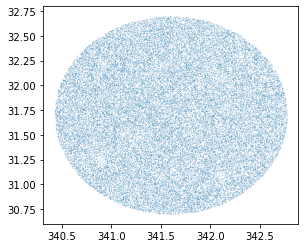

In [4]:
fig, ax = plt.subplots()
ax.scatter(res['ra'], res['dec'], marker='.', s=0.01)
ax.set_aspect('equal')

... and re-use the work from the other day:

In [5]:
import visutils
visutils.interactive_hess(res['g'], res['g']-res['r']);

interactive(children=(IntSlider(value=50, continuous_update=False, description='gridsize', max=300, min=50), O…

Now for a different field (direction on the sky):

In [6]:
query = """
SELECT
  s.ra, s.dec,
  s.dered_g as g, s.dered_r as r,
  s.err_g, s.err_r,
  s.flags
  
FROM
  dbo.fGetNearbyObjEq(229.0128, -0.1082, 30) AS n
  JOIN Star AS s ON n.objID = s.objID
  
WHERE
  g - r BETWEEN -0.5 AND 2.5
  AND g BETWEEN 14 and 24
"""

res = SDSS.query_sql(query, timeout=3600)
print(len(res))
res[:2]

11976


ra,dec,g,r,err_g,err_r,flags
float64,float64,float64,float64,float64,float64,int64
229.2421282049,-0.00346693929358043,23.26677,22.42156,0.2125325,0.1543521,35253360001808
229.243685997061,-0.00922491026160006,19.49657,19.21675,0.01275396,0.01270508,193583035584528


In [7]:
visutils.interactive_hess(res['g'], res['g']-res['r']);

interactive(children=(IntSlider(value=50, continuous_update=False, description='gridsize', max=300, min=50), O…

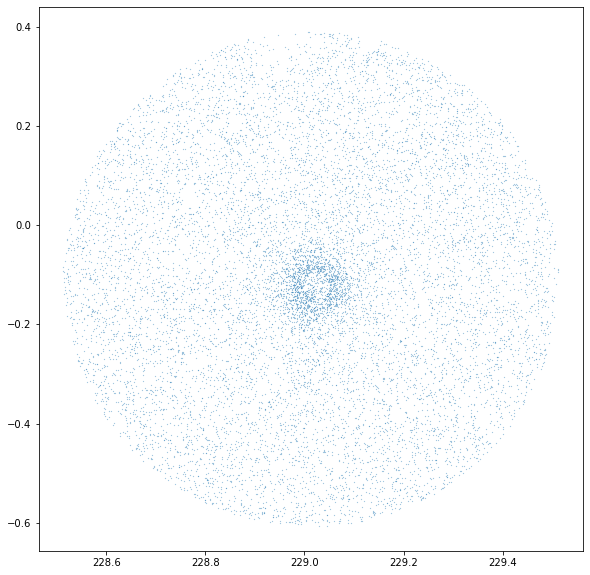

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(res['ra'], res['dec'], marker='.', s=0.1)
ax.set_aspect('equal')

This is the globular cluster [Palomar 5](https://en.wikipedia.org/wiki/Palomar_5).

## A note about timeouts and limits

To be fair to other users, queries run from SkyServer search tools are restricted in how long they can run and how much output they return, by timeouts and row limits. See the [Query Limits help page](https://skyserver.sdss.org/dr14/en/help/docs/limits.aspx) to learn what these timeouts are. Queries taking longer than allowed cannot be executed through this interface; you have to use [CasJobs](http://skyserver.sdss.org/CasJobs/) instead (manually).

## More examples

Astroquery is a very large package, supporting many different sources of data. You can find further examples of what's possible with astroquery at https://astroquery.readthedocs.io/en/latest/gallery.html